In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!unrar x  '/content/gdrive/My Drive/Copy of BelgiumTSC.rar'

In [0]:
import glob
from skimage.transform import resize
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import skimage.transform
import tensorflow as tf
import os
import cv2

In [0]:
def read_dataset(Directory):
  labels = []
  images = []
 
  directories = [direc for direc in os.listdir(Directory) 
                   if os.path.isdir(os.path.join(Directory, direc))]

  for direc in directories:
        label = os.path.join(Directory, direc)
        img_names = [os.path.join(label, img) 
                      for img in os.listdir(label) if img.endswith(".ppm")]
       
        for img in img_names:
          imag = cv2.imread(img)
          imag = skimage.transform.resize(imag, (75,75), mode='constant')
          images.append(imag)
          labels.append(int(direc))

  return images, labels

In [0]:
images, labels = read_dataset('/content/BelgiumTSC/Training/')
images_test, labels_test = read_dataset('/content/BelgiumTSC/Testing/')

In [0]:
np_labels = np.array(labels).astype(np.float32)
np_images = np.array(images).astype(np.float32)
print("labels: ", np_labels.shape, "\nimages: ", np_images.shape)

labels:  (4575,) 
images:  (4575, 75, 75, 3)


In [0]:
np_test_labels = np.array(labels_test).astype(np.float32)
np_test_images = np.array(images_test).astype(np.float32)
print("images: ", np_test_images.shape, "\nlabels: ", np_test_labels.shape)

images:  (2520, 75, 75, 3) 
labels:  (2520,)


In [0]:
IMG_SHAPE = (75, 75, 3)
#base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

In [0]:
feature_batch= base_model(np_images)

In [0]:
base_model.trainable = False

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4575, 1536)


In [0]:
prediction_layer = tf.keras.layers.Dense(62,activation='linear')
dropp =tf.keras.layers.Dropout(0.4)
dropp2 =tf.keras.layers.Dropout(0.5)
prediction_layer2 = tf.keras.layers.Dense(1536,activation='relu')
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

In [0]:
model = tf.keras.Sequential([
  base_model,
  dropp,
  global_average_layer,
  dropp2,
  prediction_layer2,
  prediction_layer
])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 1536)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1536)              2360832   
_________________________________________________________________
dense_2 (Dense)              (None, 62)                95294     
Total params: 56,792,862
Trainable params: 2,456,126
Non-trainable params: 54,336,736
__________________________________

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(np_images, np_labels, test_size=0.05, random_state=42)

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_valid,y_valid))

Epoch 1/10
136/136 [==============================] - 16s 119ms/step - loss: 1.9371 - accuracy: 0.5888 - val_loss: 0.7847 - val_accuracy: 0.7948
Epoch 2/10
136/136 [==============================] - 12s 90ms/step - loss: 0.9532 - accuracy: 0.7462 - val_loss: 0.5485 - val_accuracy: 0.8472
Epoch 3/10
136/136 [==============================] - 13s 93ms/step - loss: 0.7248 - accuracy: 0.7991 - val_loss: 0.4823 - val_accuracy: 0.8297
Epoch 4/10
136/136 [==============================] - 12s 91ms/step - loss: 0.6196 - accuracy: 0.8185 - val_loss: 0.4610 - val_accuracy: 0.8603
Epoch 5/10
136/136 [==============================] - 12s 90ms/step - loss: 0.5345 - accuracy: 0.8359 - val_loss: 0.3882 - val_accuracy: 0.8908
Epoch 6/10
136/136 [==============================] - 12s 90ms/step - loss: 0.4816 - accuracy: 0.8566 - val_loss: 0.4057 - val_accuracy: 0.8865
Epoch 7/10
136/136 [==============================] - 12s 90ms/step - loss: 0.4476 - accuracy: 0.8663 - val_loss: 0.3597 - val_accuracy

In [0]:
test_loss, test_acc = model.evaluate(np_test_images,  np_test_labels, verbose=2)

79/79 - 7s - loss: 0.4885 - accuracy: 0.8619


In [0]:
base_model.trainable = True
print("original layers in the base model before fine tuning: ", len(base_model.layers))
fine_tune = 100
for layer in base_model.layers[:fine_tune]:
  layer.trainable =  False

original layers in the base model before fine tuning:  780


In [0]:
print("trainable variables after fine tuning: ",len(model.trainable_variables))

trainable variables after fine tuning:  428


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 1536)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1536)              2360832   
_________________________________________________________________
dense_2 (Dense)              (None, 62)                95294     
Total params: 56,792,862
Trainable params: 55,964,750
Non-trainable params: 828,112
____________________________________

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid),initial_epoch=history.epoch[-1])

Epoch 10/20
136/136 [==============================] - 41s 301ms/step - loss: 0.7081 - accuracy: 0.8219 - val_loss: 0.2977 - val_accuracy: 0.9039
Epoch 11/20
136/136 [==============================] - 36s 267ms/step - loss: 0.2560 - accuracy: 0.9296 - val_loss: 1.0839 - val_accuracy: 0.8690
Epoch 12/20
136/136 [==============================] - 36s 267ms/step - loss: 0.2376 - accuracy: 0.9489 - val_loss: 0.6071 - val_accuracy: 0.9345
Epoch 13/20
136/136 [==============================] - 36s 267ms/step - loss: 0.1123 - accuracy: 0.9699 - val_loss: 0.3424 - val_accuracy: 0.9432
Epoch 14/20
136/136 [==============================] - 36s 267ms/step - loss: 0.1513 - accuracy: 0.9666 - val_loss: 0.1365 - val_accuracy: 0.9651
Epoch 15/20
136/136 [==============================] - 36s 267ms/step - loss: 0.0948 - accuracy: 0.9786 - val_loss: 1.1045 - val_accuracy: 0.8821
Epoch 16/20
136/136 [==============================] - 36s 267ms/step - loss: 0.0603 - accuracy: 0.9862 - val_loss: 0.0664 -

In [0]:
test_loss, test_acc = model.evaluate(np_test_images,  np_test_labels, verbose=2)

79/79 - 6s - loss: 0.1599 - accuracy: 0.9734


In [0]:
predict = np.argmax(model.predict(np_test_images), axis = 1)

In [0]:
labelCon = []
for i in range(62):
  labelCon.append(i)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(np_test_labels, predict , labelCon))

Confusion Matrix
[[  6   0   0 ...   0   0   0]
 [  0  27   0 ...   0   0   0]
 [  0   0   7 ...   0   0   0]
 ...
 [  0   5   0 ...  12   0   0]
 [  0   0   0 ...   0  11   0]
 [  0   0   0 ...   0   0 105]]


In [0]:
print('Classification Report')
print(classification_report(np_test_labels, predict , labelCon))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.73      1.00      0.84        27
           2       0.78      1.00      0.88         7
           3       0.86      1.00      0.92         6
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         6
           7       1.00      0.97      0.98        90
           8       0.67      1.00      0.80        12
           9       0.00      0.00      0.00         0
          10       1.00      0.96      0.98        28
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00         3
          13       1.00      0.87      0.93        39
          14       1.00      0.47      0.64        15
          15       0.00      0.00      0.00         0
          16       0.60      1.00      0.75        12
     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
import pandas as pd
con_mat = tf.math.confusion_matrix(labels=np_test_labels, predictions=predict).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = labelCon, columns = labelCon)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


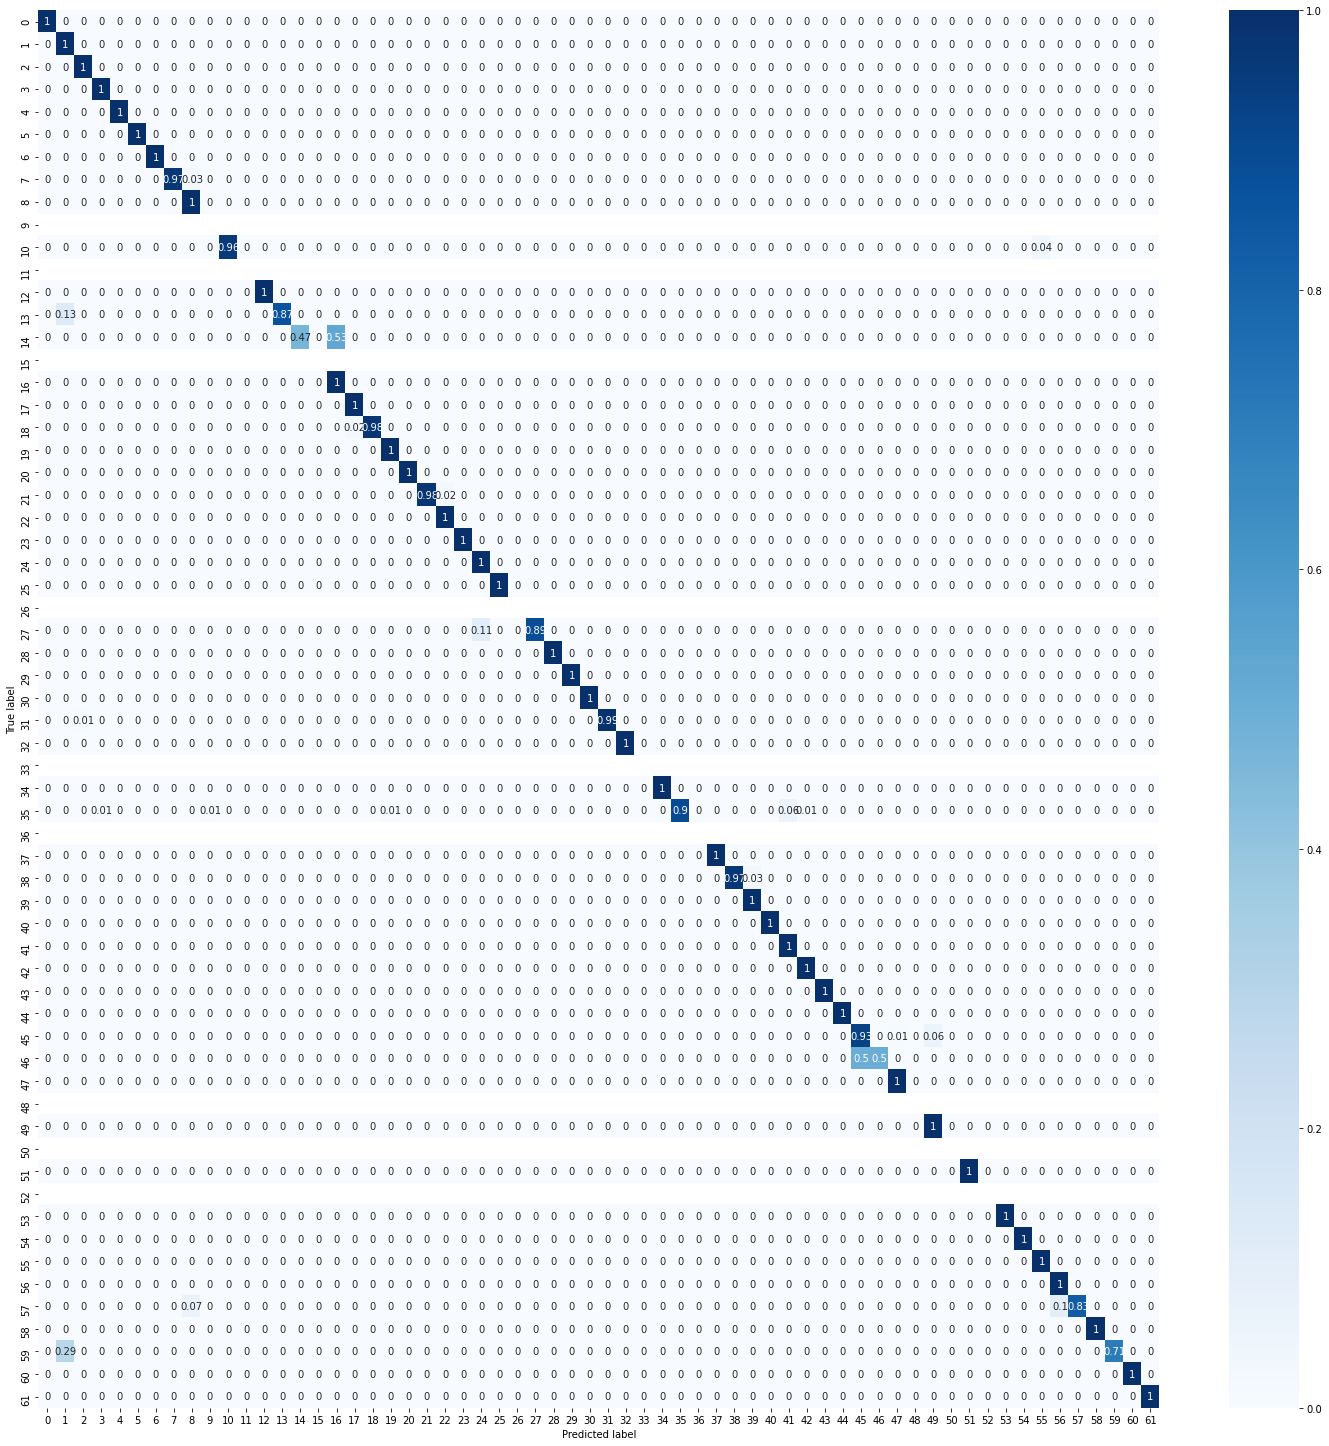

In [0]:
import seaborn as sns
figure = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()